In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display, HTML
from collections import defaultdict, deque

import torch
import torch.nn as nn
import torch.optim as optim
from livelossplot import PlotLosses

# Fix the dying kernel problem (only a problem in some installations - you can remove it, if it works without it)
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

D:\Program Files\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the dataset for recommenders

In [2]:
data_path = os.path.join("data", "hotel_data")

interactions_df = pd.read_csv(os.path.join(data_path, "hotel_data_interactions_df.csv"), index_col=0)

base_item_features = ['term', 'length_of_stay_bucket', 'rate_plan', 'room_segment', 'n_people_bucket', 'weekend_stay']

column_values_dict = {
    'term': ['WinterVacation', 'Easter', 'OffSeason', 'HighSeason', 'LowSeason', 'MayLongWeekend', 'NewYear', 'Christmas'],
    'length_of_stay_bucket': ['[0-1]', '[2-3]', '[4-7]', '[8-inf]'],
    'rate_plan': ['Standard', 'Nonref'],
    'room_segment': ['[0-160]', '[160-260]', '[260-360]', '[360-500]', '[500-900]'],
    'n_people_bucket': ['[1-1]', '[2-2]', '[3-4]', '[5-inf]'],
    'weekend_stay': ['True', 'False']
}

interactions_df.loc[:, 'term'] = pd.Categorical(
    interactions_df['term'], categories=column_values_dict['term'])
interactions_df.loc[:, 'length_of_stay_bucket'] = pd.Categorical(
    interactions_df['length_of_stay_bucket'], categories=column_values_dict['length_of_stay_bucket'])
interactions_df.loc[:, 'rate_plan'] = pd.Categorical(
    interactions_df['rate_plan'], categories=column_values_dict['rate_plan'])
interactions_df.loc[:, 'room_segment'] = pd.Categorical(
    interactions_df['room_segment'], categories=column_values_dict['room_segment'])
interactions_df.loc[:, 'n_people_bucket'] = pd.Categorical(
    interactions_df['n_people_bucket'], categories=column_values_dict['n_people_bucket'])
interactions_df.loc[:, 'weekend_stay'] = interactions_df['weekend_stay'].astype('str')
interactions_df.loc[:, 'weekend_stay'] = pd.Categorical(
    interactions_df['weekend_stay'], categories=column_values_dict['weekend_stay'])

display(HTML(interactions_df.head(15).to_html()))

,user_id,item_id,term,length_of_stay_bucket,rate_plan,room_segment,n_people_bucket,weekend_stay
0,1,0,WinterVacation,[2-3],Standard,[260-360],[5-inf],True
1,2,1,WinterVacation,[2-3],Standard,[160-260],[3-4],True
2,3,2,WinterVacation,[2-3],Standard,[160-260],[2-2],False
3,4,3,WinterVacation,[4-7],Standard,[160-260],[3-4],True
4,5,4,WinterVacation,[4-7],Standard,[0-160],[2-2],True
5,6,5,Easter,[4-7],Standard,[260-360],[5-inf],True
6,7,6,OffSeason,[2-3],Standard,[260-360],[5-inf],True
7,8,7,HighSeason,[2-3],Standard,[160-260],[1-1],True
8,9,8,HighSeason,[2-3],Standard,[0-160],[1-1],True
9,8,7,HighSeason,[2-3],Standard,[160-260],[1-1],True


In [3]:
# Function for user features from my first project
def probability_distribution(interactions_df):
    # prepare result DataFrame template
    users_df = pd.DataFrame(interactions_df.loc[:, "user_id"].unique(), columns=['user_id'])

    inter_df_copy = interactions_df.copy()
    inter_df_copy['val'] = 1
    
    # Calculate the probability distribution for every possible choice
#     for bucket_feature in ['term', 'length_of_stay_bucket', 'rate_plan', 'room_segment', 'n_people_bucket', 'weekend_stay']:
#         feature_df = inter_df_copy.loc[:, ['user_id', bucket_feature, 'val']]
#         feature_df = inter_df_copy.pivot_table(index='user_id', columns=bucket_feature, values='val', aggfunc='count')
#         feature_df = feature_df / feature_df.sum(axis=1).values.reshape(-1, 1)  # Summed choices dive by row sum which is equal to number of interacion of each user
#         feature_df = feature_df.rename_axis(None, axis=1).fillna(0)
        
#         # Make sure that all choices are included, if not add them as new column with deffault value set to 0
#         missing_elements = list(set(inter_df_copy[bucket_feature].unique().categories.tolist())-set(inter_df_copy[bucket_feature].unique()))
#         feature_df[missing_elements] = 0
        
#         feature_df = feature_df.add_prefix('user_' + bucket_feature + '_')
#         users_df = pd.merge(users_df, feature_df, on='user_id', how="left")

    # Calculate the average of numerical buckets choice for every user
    numerical_buckets = {
        'length_of_stay_bucket': {'[0-1]': 0.5, '[2-3]': 1.5, '[4-7]': 5.5, '[8-inf]': 10},
        'room_segment': {'[0-160]': 80, '[160-260]': 210, '[260-360]': 310, '[360-500]': 450, '[500-900]': 700},
        'n_people_bucket': {'[1-1]': 1, '[2-2]': 2, '[3-4]': 3.5, '[5-inf]': 7},
    }

    for numerical_feature in numerical_buckets:
        tmp_df = pd.DataFrame(interactions_df.loc[:, "user_id"].unique(), columns=['user_id'])
        
        inter_df_copy.loc[:, numerical_feature] = inter_df_copy.loc[:, numerical_feature].apply(lambda choice: numerical_buckets[numerical_feature][choice]).astype(np.float64)
        
        # reset_index() because otherwise it's assign values to new column by associating tmp_df.index with column index
        new_column_name = "mean_" + numerical_feature
        tmp_df.loc[:, new_column_name] = inter_df_copy.groupby(by="user_id")[numerical_feature].apply(lambda value: np.mean(value)).reset_index(drop=True)

        users_df = pd.merge(users_df, tmp_df, on="user_id", how="left")

        # Fix bug - map_npeople_to_npeople_buckets return None wich is next skipped by pd.pivot_table which cause loss item_id and add NaN during merging
        users_df = users_df.rename_axis(None, axis=1).fillna(0)

    users_df = users_df.reset_index(drop=True)

    return users_df

# (Optional) Prepare numerical user features

The method below is left here for convenience if you want to experiment with content-based user features as an input for your neural network.

In [4]:
def n_to_p(l):
    n = sum(l)
    return [x / n for x in l] if n > 0 else l

def calculate_p(x, values):
    counts = [0]*len(values)
    for v in x:
        counts[values.index(v)] += 1

    return n_to_p(counts)

def prepare_users_df_default(interactions_df):

    users_df = interactions_df.loc[:, ["user_id"]]
    users_df = users_df.groupby("user_id").first().reset_index(drop=False)
    
    user_features = []

    for column in base_item_features:

        column_values = column_values_dict[column]
        df = interactions_df.loc[:, ['user_id', column]]
        df = df.groupby('user_id').aggregate(lambda x: list(x)).reset_index(drop=False)

        def calc_p(x):
            return calculate_p(x, column_values)
         
        # Fix bug - map_npeople_to_npeople_buckets return None wich is next skipped by pd.pivot_table which cause loss item_id and add NaN during merging
        df[column] = df[column].rename_axis(None, axis=1).fillna(0)
        display(df.isnull().values.sum()) # Bug - map_npeople_to_npeople_buckets return Null in specific case
        df.loc[:, column] = df[column].apply(lambda x: calc_p(x)) #ERROR WITH NANN IN x

        p_columns = []
        for i in range(len(column_values)):
            p_columns.append("user_" + column + "_" + column_values[i])
            df.loc[:, p_columns[i]] = df[column].apply(lambda x: x[i])
            user_features.append(p_columns[i])

        users_df = pd.merge(users_df, df.loc[:, ['user_id'] + p_columns], on=["user_id"])
    
    return users_df, user_features
    

def prepare_users_df(interactions_df):
    # Case II with avg of numerical values
    users_df = probability_distribution(interactions_df)
    
    user_features = users_df.columns[1:].tolist()
    
    return users_df, user_features

users_df, user_features = prepare_users_df(interactions_df)

print(user_features)

display(HTML(users_df.loc[users_df['user_id'].isin([706, 1736, 7779, 96, 1, 50, 115])].head(15).to_html()))

['mean_length_of_stay_bucket', 'mean_room_segment', 'mean_n_people_bucket']


,user_id,mean_length_of_stay_bucket,mean_room_segment,mean_n_people_bucket
0,1,3.136364,223.636364,2.727273
40,50,1.847826,253.478261,4.304348
321,706,1.500000,210.000000,3.500000
547,115,1.500000,210.000000,2.000000
1270,1736,5.500000,210.000000,3.500000
2785,96,0.500000,210.000000,3.500000
11527,7779,1.500000,80.000000,2.000000


# (Optional) Prepare numerical item features

The method below is left here for convenience if you want to experiment with content-based item features as an input for your neural network.

In [5]:
# Function for item features from my first project
def item_numerical_features(interactions_df):
    # prepare result DataFrame template
    item_df = pd.DataFrame(interactions_df.loc[:, "item_id"].unique(), columns=['item_id'])

    inter_df_copy = interactions_df.copy()
    inter_df_copy['val'] = 1
    
    # Calculate the probability distribution for every possible choice
    for bucket_feature in ['term', 'length_of_stay_bucket', 'rate_plan', 'room_segment', 'n_people_bucket', 'weekend_stay']:
        feature_df = inter_df_copy.loc[:, ['item_id', bucket_feature, 'val']]
        feature_df = inter_df_copy.pivot_table(index='item_id', columns=bucket_feature, values='val')
        feature_df = feature_df / feature_df.sum(axis=1).values.reshape(-1, 1)  # Summed choices dive by row sum which is equal to number of interacion of each user
        feature_df = feature_df.rename_axis(None, axis=1).fillna(0)

        # Make sure that all choices are included, if not add them as new column with deffault value set to 0
        missing_elements = list(set(inter_df_copy[bucket_feature].unique().categories.tolist())-set(inter_df_copy[bucket_feature].unique()))
        feature_df[missing_elements] = 0
        
        feature_df = feature_df.add_prefix('item_' + bucket_feature + '_')
        item_df = pd.merge(item_df, feature_df, on='item_id', how="left")

        # Fix bug - map_npeople_to_npeople_buckets return None wich is next skipped by pd.pivot_table which cause loss item_id and add NaN during merging
        item_df = item_df.rename_axis(None, axis=1).fillna(0)

    # Calculate the popularity of each item
    # TODO Fix Bug - this code overwrite 'interactions_df' value passed to function on the next call
#     item_popularity = inter_df_copy.groupby(by='item_id', as_index=False)['val'].count().reset_index(drop=True).copy()
#     item_popularity['val'] = item_popularity['val'].apply(lambda value: np.divide(value, 100))
#     item_popularity = item_popularity.rename(columns={'val': 'item_popularity'})

#     item_df = pd.merge(item_df, item_popularity, on='item_id', how='left')

    item_df = item_df.reset_index(drop=True)

    return item_df


In [6]:
def map_items_to_onehot(df):
    one_hot = pd.get_dummies(df.loc[:, base_item_features])
    df = df.drop(base_item_features, axis = 1)
    df = df.join(one_hot)
    
    return df, list(one_hot.columns)

def prepare_items_df_default(interactions_df):
    items_df = interactions_df.loc[:, ["item_id"] + base_item_features].drop_duplicates()
    
    items_df, item_features = map_items_to_onehot(items_df)
    
    return items_df, item_features

def prepare_items_df(interactions_df):
    
    items_df = item_numerical_features(interactions_df)
    item_features = items_df.columns[1:].tolist()

    return items_df, item_features

items_df, item_features = prepare_items_df(interactions_df)

print(item_features)

display(HTML(items_df.loc[items_df['item_id'].isin([0, 1, 2, 3, 4, 5, 6])].head(15).to_html()))

['item_term_WinterVacation', 'item_term_Easter', 'item_term_OffSeason', 'item_term_HighSeason', 'item_term_LowSeason', 'item_term_MayLongWeekend', 'item_term_NewYear', 'item_term_Christmas', 'item_length_of_stay_bucket_[0-1]', 'item_length_of_stay_bucket_[2-3]', 'item_length_of_stay_bucket_[4-7]', 'item_length_of_stay_bucket_[8-inf]', 'item_rate_plan_Standard', 'item_rate_plan_Nonref', 'item_room_segment_[0-160]', 'item_room_segment_[160-260]', 'item_room_segment_[260-360]', 'item_room_segment_[360-500]', 'item_room_segment_[500-900]', 'item_n_people_bucket_[1-1]', 'item_n_people_bucket_[2-2]', 'item_n_people_bucket_[3-4]', 'item_n_people_bucket_[5-inf]', 'item_weekend_stay_True', 'item_weekend_stay_False']


,item_id,item_term_WinterVacation,item_term_Easter,item_term_OffSeason,item_term_HighSeason,item_term_LowSeason,item_term_MayLongWeekend,item_term_NewYear,item_term_Christmas,item_length_of_stay_bucket_[0-1],item_length_of_stay_bucket_[2-3],item_length_of_stay_bucket_[4-7],item_length_of_stay_bucket_[8-inf],item_rate_plan_Standard,item_rate_plan_Nonref,item_room_segment_[0-160],item_room_segment_[160-260],item_room_segment_[260-360],item_room_segment_[360-500],item_room_segment_[500-900],item_n_people_bucket_[1-1],item_n_people_bucket_[2-2],item_n_people_bucket_[3-4],item_n_people_bucket_[5-inf],item_weekend_stay_True,item_weekend_stay_False
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0
1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,1.0,0.0
2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,1.0
3,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,1.0,0.0
4,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0.0,1.0,0.0
5,5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0
6,6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0


# Neural network recommender

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Code a recommender based on a neural network model. You are free to choose any network architecture you find appropriate. The network can use the interaction vectors for users and items, embeddings of users and items, as well as user and item features (you can use the features you developed in the first project).

Remember to keep control over randomness - in the init method add the seed as a parameter and initialize the random seed generator with that seed (both for numpy and pytorch):

```python
self.seed = seed
self.rng = np.random.RandomState(seed=seed)
```
in the network model:
```python
self.seed = torch.manual_seed(seed)
```

You are encouraged to experiment with:
  - the number of layers in the network, the number of neurons and different activation functions,
  - different optimizers and their parameters,
  - batch size and the number of epochs,
  - embedding layers,
  - content-based features of both users and items.

In [7]:
from recommenders.recommender import Recommender


class MLPModel(nn.Module):
    def __init__(self, n_items, n_users, embedding_dim, seed):
        super().__init__()

        self.seed = torch.manual_seed(seed)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.fc1 = nn.Linear(2 * embedding_dim, 32, bias=False)
        
        self.fc2 = nn.Linear(32, 16, bias=False)
        self.fc3 = nn.Linear(16, 1, bias=False)

    def forward(self, x):
        user = x[:, 0]
        item = x[:, 1]
        
        user_embedding = self.user_embedding(user)
        item_embedding = self.item_embedding(item)
        
        x = torch.cat([user_embedding, item_embedding], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))

        return x

In [8]:
class GMFModel(nn.Module):
    def __init__(self, n_items, n_users, embedding_dim, seed):
        super().__init__()

        self.seed = torch.manual_seed(seed)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.fc = nn.Linear(embedding_dim, 1, bias=False)

    def forward(self, x):
        user_ids = x[:, 0]
        item_ids = x[:, 1]
        user_embedding = self.user_embedding(user_ids)
        item_embedding = self.item_embedding(item_ids)
        x = self.fc(user_embedding * item_embedding)
        x = torch.sigmoid(x)

        return x

In [9]:
class NeuMFModel(nn.Module):
    def __init__(self, n_items, n_users, gmf_embedding_dim, mlp_embedding_dim, hidden_dim, seed):
        super().__init__()

        self.seed = torch.manual_seed(seed)

        # GMF

        self.gmf_user_embedding = nn.Embedding(n_users, gmf_embedding_dim)
        self.gmf_item_embedding = nn.Embedding(n_items, gmf_embedding_dim)

        # MLP

        self.mlp_user_embedding = nn.Embedding(n_users, mlp_embedding_dim)
        self.mlp_item_embedding = nn.Embedding(n_items, mlp_embedding_dim)
        self.mlp_fc1 = nn.Linear(2 * mlp_embedding_dim, hidden_dim, bias=False)
        self.mlp_fc2 = nn.Linear(hidden_dim, int(hidden_dim / 2), bias=False)

        # Merge

        self.fc = nn.Linear(gmf_embedding_dim + int(hidden_dim / 2), 1, bias=False)

    def forward(self, x):
        user = x[:, 0]
        item = x[:, 1]

        # GMF

        gmf_user_embedding = self.gmf_user_embedding(user)
        gmf_item_embedding = self.gmf_item_embedding(item)
        gmf_x = gmf_user_embedding * gmf_item_embedding

        # MLP

        mlp_user_embedding = self.mlp_user_embedding(user)
        mlp_item_embedding = self.mlp_item_embedding(item)
        mlp_x = torch.cat([mlp_user_embedding, mlp_item_embedding], dim=1)
        mlp_x = torch.relu(self.mlp_fc1(mlp_x))
        mlp_x = torch.relu(self.mlp_fc2(mlp_x))

        # Final score

        x = torch.cat([gmf_x, mlp_x], dim=1)
        x = torch.sigmoid(self.fc(x))

        return x

In [10]:
"""
Hidden Layers dont work 
Embedding - not used
Cosinf similarity - not work - why?
"""

class MyContentBaseNet(nn.Module):
    def __init__(self, n_features, seed):
        super().__init__()

        self.seed = torch.manual_seed(seed)
        self.n_features = n_features
        self.cos = nn.CosineSimilarity()

        # Input layer
        self.fc1 = nn.Linear(n_features, 32, bias=False)
        
        # Hidden layers
        self.fc2 = nn.Linear(32, 16, bias=False)
        self.fc3 = nn.Linear(16, 8, bias=False)
        self.fc4 = nn.Linear(8, 4, bias=False)

    
    def forward(self, x):
       
        # cosine similarity for different dimensions
        #    np.dot(A,B)/(norm(A, axis=1)*norm(B))
        x = torch.relu(self.fc1(x.float()))
        # x = torch.relu(self.cos(x.float()))
        
        x = torch.relu(self.fc2(x.float()))
        x = torch.relu(self.fc3(x.float()))
        x = torch.sigmoid(self.fc4(x.float()))
        # ERROR
        #@ RuntimeError: mat1 and mat2 shapes cannot be multiplied (5x32 and 21x16)
        return x

In [11]:
# Hybrid model with content-based features - at least i tried to be
# use product and user features + rating + context
class HybridNNRecommender(Recommender):
    """
    Linear recommender class based on user and item features.
    """
    
    def __init__(self, seed=6789, n_neg_per_pos=5, print_type='live', 
                n_epochs=5,
                batch_size =5,
                learning_rate=0.001,
                embedding_dim=6,
                device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
                weight_decay=0.0001
                ):
        """
        Initialize recommender params and variables.
        """
        self.nn_model = None
        self.n_neg_per_pos = int(n_neg_per_pos)
        
        self.recommender_df = pd.DataFrame(columns=['user_id', 'item_id', 'score'])
        self.users_df = None
        self.user_features = None
        
        self.interactions_df = None
        self.item_id_mapping = None
        self.user_id_mapping = None
        self.item_id_reverse_mapping = None
        self.user_id_reverse_mapping = None
        
        self.seed = seed
        self.rng = np.random.RandomState(seed=seed)
        
        # You can add more arguments if needed
        self.print_type = print_type
        self.validation_set_size = 0.2
        
        self.config = {}
        
        params={
            'n_epochs': n_epochs,
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'embedding_dim': int(embedding_dim),
            'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
            'weight_decay': weight_decay,
        }
        self.setup_config(params)
        
    def setup_config(self, params):
        for key, value in params.items():
            self.config[key] = value
    
    def generate_negative_interactions_list(self, n_users, n_items, n):       
        negative_interactions = []
        
        while len(negative_interactions) < n:
            users_ids = self.rng.choice(np.arange(n_users), size=np.max(users_df['user_id']))
            items_ids = self.rng.choice(np.arange(n_items), size=np.max(users_df['user_id']))
            j = 0
            while j < len(users_df['user_id']) and len(negative_interactions) < n:
                if(users_ids, items_ids, 0):
                    negative_interactions.append([users_ids[j], items_ids[j], 0])
                j += 1

    def fit(self, interactions_df, users_df, items_df):
        """
        Training of the recommender.

        :param pd.DataFrame interactions_df: DataFrame with recorded interactions between users and items
            defined by user_id, item_id and features of the interaction.
        :param pd.DataFrame users_df: DataFrame with users and their features defined by
            user_id and the user feature columns.
        :param pd.DataFrame items_df: DataFrame with items and their features defined
            by item_id and the item feature columns.
        """

        recommend_df = interactions_df.copy()
        recommend_df.loc[:, 'interacted'] = int(1)

        # Prepare users_df and items_df 
        # (optional - use only if you want to train a hybrid model with content-based features)
        users_df, user_features = prepare_users_df(recommend_df)
        self.users_df = users_df
        self.user_features = user_features

        items_df_cp, item_features = prepare_items_df(recommend_df)
        items_df_cp = items_df_cp.loc[:, ['item_id'] + item_features]

        
        ## Get the number of items and users
        self.interactions_df = recommend_df.copy()


        # Generate negative interactions
        negative_interactions = []
        
        n_users = np.max(recommend_df['user_id']) + 1
        n_items = np.max(recommend_df['item_id']) + 1
        negative_interactions = self.generate_negative_interactions_list(n_users, n_items, self.n_neg_per_pos * len(recommend_df))

        recommend_df = pd.concat(
            [recommend_df, pd.DataFrame(negative_interactions, columns=['user_id', 'item_id', 'interacted'])])
        recommend_df = recommend_df.reset_index(drop=True)
        
        # Merge user and item features
        # (optional - use only if you want to train a hybrid model with content-based features)
        
        recommend_df = pd.merge(recommend_df, users_df, on=['user_id'])
        recommend_df = pd.merge(recommend_df, items_df_cp, on=['item_id'])
        
        ## 
        self.model_features = self.user_features + item_features

        # Initialize the neural network model
        self.nn_model = MyContentBaseNet(len(self.model_features), self.seed)
  
        self.nn_model.train()
        self.nn_model.to(self.config['device'])
        self.optimizer = optim.Adam(self.nn_model.parameters(), lr=self.config['learning_rate'], weight_decay=self.config['weight_decay'])
        #self.optimizer = optim.SGD(self.nn_model.parameters(), lr=self.config['learning_rate'])

        # Initialize losses and loss visualization
        if self.print_type is not None and self.print_type == 'live':
            liveloss = PlotLosses()

        training_losses = deque(maxlen=50)
        training_avg_losses = []
        training_epoch_losses = []
        validation_losses = deque(maxlen=50)
        validation_avg_losses = []
        validation_epoch_losses = []
        last_training_total_loss = 0.0
        last_validation_total_loss = 0.0
        
        
        # Split the data
        interaction_ids = self.rng.permutation(len(recommend_df))
        train_validation_slice_idx = int(len(recommend_df) * (1 - self.validation_set_size))
        training_ids = interaction_ids[:train_validation_slice_idx]
        validation_ids = interaction_ids[train_validation_slice_idx:]

        
        # Train the model
        for epoch in range(int(self.config['n_epochs'])):
            if self.print_type is not None and self.print_type == 'live':
                logs = {}
                
            # Train

            training_losses.clear()
            training_total_loss = 0.0
            
            self.rng.shuffle(training_ids)
            
            batch_idx = 0
            n_batches = int(np.ceil(len(training_ids) / int(self.config['batch_size'])))
            
            for batch_idx in range(n_batches):
                    
                batch_ids = training_ids[(batch_idx * int(self.config['batch_size'])):((batch_idx + 1) * int(self.config['batch_size']))]
                
                batch = recommend_df.iloc[batch_ids]
                batch_input = torch.from_numpy(batch.loc[:, self.model_features].values).long().to(self.config['device']) # x train - add extra informations for train set
                y_target = torch.from_numpy(batch.loc[:, ['interacted']].astype(int).values).float().to(self.config['device']) # y train
                
                # Create responses

                y = self.nn_model(batch_input).clip(0.000001, 0.999999)

                # Define loss and backpropagate

                self.optimizer.zero_grad()
                loss = -(y_target * y.log() + (1 - y_target) * (1 - y).log()).sum() # use metric to calculate loss
                
                loss.backward()
                self.optimizer.step()
                
                training_total_loss += loss.item()
                
                training_losses.append(loss.item())
                training_avg_losses.append(np.mean(training_losses))
                
            # Validate
            validation_total_loss = 0.0

            ## Use the same set for training and tests - TODO add special features only for train not tests set - according to context-aware hybrid model
            batch = recommend_df.iloc[validation_ids]
            batch_input = torch.from_numpy(batch.loc[:, self.model_features].values).long().to(self.config['device'])
            y_target = torch.from_numpy(batch.loc[:, ['interacted']].astype(int).values).float().to(self.config['device'])

            # Create responses

            y = self.nn_model(batch_input).clip(0.000001, 0.999999)

            # Calculate validation loss

            loss = -(y_target * y.log() + (1 - y_target) * (1 - y).log()).sum()
            validation_total_loss += loss.item()
                
            # Save and print epoch losses
            training_last_avg_loss = training_total_loss / len(training_ids)
            validation_last_avg_loss = validation_total_loss / len(validation_ids)

            if self.print_type is not None and self.print_type == 'live' and epoch >= 0:
                logs['loss'] = training_last_avg_loss
                logs['val_loss'] = validation_last_avg_loss
                liveloss.update(logs)
                liveloss.send()

#         # Find the most popular items for the cold start problem
#         offers_count = recommend_df.loc[:, self.model_features].groupby(by='item_id').count()
#         offers_count = offers_count.sort_values('user_id', ascending=False)
#         self.most_popular_items = offers_count.index
        
    def recommend(self, users_df, items_df, n_recommendations=1):
        """
        Serving of recommendations. Scores items in items_df for each user in users_df and returns
        top n_recommendations for each user.

        :param pd.DataFrame users_df: DataFrame with users and their features for which
            recommendations should be generated.
        :param pd.DataFrame items_df: DataFrame with items and their features which should be scored.
        :param int n_recommendations: Number of recommendations to be returned for each user.
        :return: DataFrame with user_id, item_id and score as columns returning n_recommendations top recommendations
            for each user.
        :rtype: pd.DataFrame
        """
        
        # Clean previous recommendations (iloc could be used alternatively)
        self.recommender_df = self.recommender_df[:0]
        
        # Prepare users_df and items_df
        # (optional - use only if you want to train a hybrid model with content-based features)
        
        users_df = users_df.loc[:, 'user_id']
        users_df = pd.merge(users_df, self.users_df, on=['user_id'], how='left').fillna(0)
        
        items_df, item_features = prepare_items_df(interactions_df)
        items_df_cp = items_df.loc[:, ['item_id'] + item_features] # its override `items_df` variable and break next iteration :/
        
        
        ## build local df - beacouse i dobnt modify interactions_df globally 
        recommend_df = self.interactions_df
        recommend_df = pd.merge(recommend_df, users_df, on=['user_id'])
        recommend_df = pd.merge(recommend_df, items_df_cp, on=['item_id'])
        
        scaled_df = recommend_df.loc[:,self.model_features]
        

        # Generate recommendations

        for idx, user in users_df.iterrows():
            recommendations = []

            user_id = user['user_id']
                
            net_input = torch.from_numpy(scaled_df.loc[:, self.model_features].values).long().to(self.config['device'])

            scores = self.nn_model(net_input).flatten().detach().cpu().numpy()

            chosen_pos = np.argsort(-scores)[:n_recommendations]

            for item_id  in chosen_pos:
                recommendations.append(
                    {
                        'user_id': user_id,
                        'item_id': item_id ,
                        'score': scores[item_id]
                    }
                )


            user_recommendations = pd.DataFrame(recommendations)

            self.recommender_df = pd.concat([self.recommender_df, user_recommendations])

        return self.recommender_df

# Quick test of the recommender

In [15]:
items_df = interactions_df.loc[:, ['item_id'] + base_item_features].drop_duplicates()

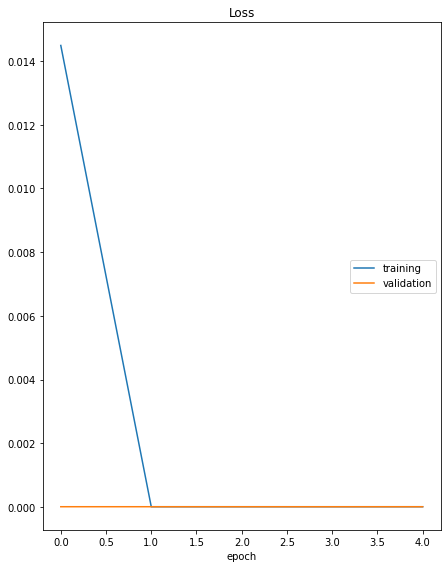

Loss
	training         	 (min:    0.000, max:    0.014, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)


In [21]:
# Fit method
hybrid_nn_recommender = HybridNNRecommender()
hybrid_nn_recommender.fit(interactions_df, None, None)

In [22]:
# Recommender method

recommendations = hybrid_nn_recommender.recommend(pd.DataFrame([[1], [2], [3], [4], [5]], columns=['user_id']), items_df, 10)

recommendations = pd.merge(recommendations, items_df, on='item_id', how='left')
display(HTML(recommendations.to_html()))

,user_id,item_id,score,term,length_of_stay_bucket,rate_plan,room_segment,n_people_bucket,weekend_stay
0,1.0,0,1.0,WinterVacation,[2-3],Standard,[260-360],[5-inf],True
1,1.0,73,1.0,Easter,[2-3],Standard,[160-260],[2-2],True
2,1.0,72,1.0,OffSeason,[2-3],Nonref,[260-360],[5-inf],True
3,1.0,71,1.0,OffSeason,[2-3],Standard,[260-360],[5-inf],False
4,1.0,70,1.0,HighSeason,[4-7],Standard,[160-260],[3-4],True
5,1.0,69,1.0,OffSeason,[2-3],Nonref,[0-160],[2-2],True
6,1.0,68,1.0,WinterVacation,[4-7],Standard,[160-260],[2-2],True
7,1.0,67,1.0,MayLongWeekend,[4-7],Nonref,[160-260],[2-2],True
8,1.0,66,1.0,OffSeason,[2-3],Standard,[0-160],[2-2],True
9,1.0,65,1.0,OffSeason,[4-7],Nonref,[260-360],[5-inf],True


# Collaborative NN Base Recommender

In [21]:
class NNRecommender(Recommender):
    """
    Linear recommender class based on user and item features.
    """
    
    def __init__(self, seed=6789, n_neg_per_pos=5, print_type='live', 
                n_epochs=5,
                batch_size =5,
                learning_rate=0.001,
                embedding_dim=6,
                device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
                weight_decay=0.0001,
                model_class=None):
        """
        Initialize recommender params and variables.
        """
        self.nn_model = None
        self.n_neg_per_pos = int(n_neg_per_pos)
        
        self.recommender_df = pd.DataFrame(columns=['user_id', 'item_id', 'score'])
        self.users_df = None
        self.user_features = None
        
        self.interactions_df = None
        self.item_id_mapping = None
        self.user_id_mapping = None
        self.item_id_reverse_mapping = None
        self.user_id_reverse_mapping = None
        
        self.seed = seed
        self.rng = np.random.RandomState(seed=seed)
        
        # You can add more arguments if needed
        self.print_type = print_type
        self.validation_set_size = 0.2
        
        # Init Config
        self.config = {}
        
        params={
            'n_epochs': n_epochs,
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'embedding_dim': int(embedding_dim),
            'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
            'weight_decay': weight_decay,
            'model_class': model_class
        }
        self.setup_config(params)
        display(self.config)
        
    def setup_config(self, params):
        for key, value in params.items():
            self.config[key] = value
    
    def generate_negative_interactions_list(self, user_ids, item_ids, n):       
        negative_interactions = []

#         for user_id, user_interactions_row in enumerate(interaction_matrix):
#             for item_id, item_interactions_column in enumerate(row):
#                 if item_interactions_column == 0:
#                     negative_interactions.append((user_id, item_id, 0))

        # generate set of all pairs
        all_pairs_set = set(zip(interactions_df['user_id'], interactions_df['item_id']))   
        
        # n -> self.config['n_neg_per_pos'] * len(interactions_df)
        while len(negative_interactions) < n:
            user_id = self.rng.choice(user_ids, 1)[0]
            item_id = self.rng.choice(item_ids, 1)[0]
            
            is_random_pair_real_pair = len(set([(user_id, item_id)]).difference(all_pairs_set)) == 0
            if not is_random_pair_real_pair:
                negative_interactions.append((user_id, item_id, 0))

        return negative_interactions
        
    def map_user_and_item(self, interactions_df):
        # Shift item ids and user ids so that they are consecutive

        unique_item_ids = interactions_df['item_id'].unique()
        self.item_id_mapping = dict(zip(unique_item_ids, list(range(len(unique_item_ids)))))
        self.item_id_reverse_mapping = dict(zip(list(range(len(unique_item_ids))), unique_item_ids))
        unique_user_ids = interactions_df['user_id'].unique()
        self.user_id_mapping = dict(zip(unique_user_ids, list(range(len(unique_user_ids)))))
        self.user_id_reverse_mapping = dict(zip(list(range(len(unique_user_ids))), unique_user_ids))

    def init_nn_model(self, model_name, n_users, n_items):
        match model_name:
            case 'MLPModel' | '0' | 0:
                self.nn_model = MLPModel(n_items, n_users, self.config['embedding_dim'], self.seed)
                return
            case 'GMFModel' | '1' | 1:
                self.nn_model = GMFModel(n_items, n_users, self.config['embedding_dim'], self.seed)
                return 
            case 'NeuMFModel' | '2' | 2:
                self.nn_model = NeuMFModel(n_items, n_users, self.config['embedding_dim'], self.config['embedding_dim'], 4, self.seed)
                return

    def fit(self, interactions_df, users_df, items_df):
        """
        Training of the recommender.

        :param pd.DataFrame interactions_df: DataFrame with recorded interactions between users and items
            defined by user_id, item_id and features of the interaction.
        :param pd.DataFrame users_df: DataFrame with users and their features defined by
            user_id and the user feature columns.
        :param pd.DataFrame items_df: DataFrame with items and their features defined
            by item_id and the item feature columns.
        """

        recommend_df = interactions_df.copy()
        
        # Prepare users_df and items_df 
        # (optional - use only if you want to train a hybrid model with content-based features)
        
        users_df, user_features = prepare_users_df(recommend_df)
        
        self.users_df = users_df
        self.user_features = user_features

        items_df_cp, item_features = prepare_items_df(recommend_df)
        items_df_cp = items_df_cp.loc[:, ['item_id'] + item_features]
        
        if(self.item_id_mapping is None or self.user_id_mapping is None):
            self.map_user_and_item(interactions_df)
            
        recommend_df['item_id'] = recommend_df['item_id'].map(self.item_id_mapping)
        recommend_df['user_id'] = recommend_df['user_id'].map(self.user_id_mapping)

        
        # Get the number of items and users
        self.interactions_df = recommend_df.copy()
        n_users = np.max(recommend_df['user_id']) + 1
        n_items = np.max(recommend_df['item_id']) + 1


        # Indicate positive interactions
        recommend_df.loc[:, 'interacted'] = 1

        # Generate negative interactions
        negative_interactions = []
        negative_interactions = self.generate_negative_interactions_list(n_users, n_items, self.n_neg_per_pos * len(recommend_df))

        recommend_df = pd.concat(
            [recommend_df, pd.DataFrame(negative_interactions, columns=['user_id', 'item_id', 'interacted'])])
        recommend_df = recommend_df.reset_index(drop=True)
        
        # Merge user and item features
        # (optional - use only if you want to train a hybrid model with content-based features)
        
        recommend_df = pd.merge(recommend_df, users_df, on=['user_id'])
        recommend_df = pd.merge(recommend_df, items_df_cp, on=['item_id'])
        
        # Initialize losses and loss visualization
        
        if self.print_type is not None and self.print_type == 'live':
            liveloss = PlotLosses()

        # Initialize the neural network model
        self.init_nn_model(self.config['model_class'], n_users, n_items)

            
        self.nn_model.train()
        self.nn_model.to(self.config['device'])
        self.optimizer = optim.Adam(self.nn_model.parameters(), lr=self.config['learning_rate'], weight_decay=self.config['weight_decay'])
    
        training_losses = deque(maxlen=50)
        training_avg_losses = []
        training_epoch_losses = []
        validation_losses = deque(maxlen=50)
        validation_avg_losses = []
        validation_epoch_losses = []
        last_training_total_loss = 0.0
        last_validation_total_loss = 0.0
        
        
        # Split the data
        interaction_ids = self.rng.permutation(len(recommend_df))
        train_validation_slice_idx = int(len(recommend_df) * (1 - self.validation_set_size))
        training_ids = interaction_ids[:train_validation_slice_idx]
        validation_ids = interaction_ids[train_validation_slice_idx:]

        
        # Train the model
        for epoch in range(int(self.config['n_epochs'])):
            if self.print_type is not None and self.print_type == 'live':
                logs = {}
                
            # Train
            
            training_losses.clear()
            training_total_loss = 0.0
            
            self.rng.shuffle(training_ids)
            
            batch_idx = 0
            n_batches = int(np.ceil(len(training_ids) / int(self.config['batch_size'])))
            
            for batch_idx in range(n_batches):
                
                batch_ids = training_ids[(batch_idx * int(self.config['batch_size'])):((batch_idx + 1) * int(self.config['batch_size']))]
                
                batch = recommend_df.loc[batch_ids]
                batch_input = torch.from_numpy(batch.loc[:, ['user_id', 'item_id']].values).long().to(self.config['device'])
                y_target = torch.from_numpy(batch.loc[:, ['interacted']].values).float().to(self.config['device'])
                
                # Create responses

                y = self.nn_model(batch_input).clip(0.000001, 0.999999)

                # Define loss and backpropagate

                self.optimizer.zero_grad()
                loss = -(y_target * y.log() + (1 - y_target) * (1 - y).log()).sum()
                
                loss.backward()
                self.optimizer.step()
                
                training_total_loss += loss.item()
                
                training_losses.append(loss.item())
                training_avg_losses.append(np.mean(training_losses))
                
            # Validate
            validation_total_loss = 0.0

            batch = recommend_df.loc[validation_ids]
            batch_input = torch.from_numpy(batch.loc[:, ['user_id', 'item_id']].values).long().to(self.config['device'])
            y_target = torch.from_numpy(batch.loc[:, ['interacted']].values).float().to(self.config['device'])

            # Create responses

            y = self.nn_model(batch_input).clip(0.000001, 0.999999)

            # Calculate validation loss

            loss = -(y_target * y.log() + (1 - y_target) * (1 - y).log()).sum()
            validation_total_loss += loss.item()
                
            # Save and print epoch losses
            training_last_avg_loss = training_total_loss / len(training_ids)
            validation_last_avg_loss = validation_total_loss / len(validation_ids)

            if self.print_type is not None and self.print_type == 'live' and epoch >= 0:
                logs['loss'] = training_last_avg_loss
                logs['val_loss'] = validation_last_avg_loss
                liveloss.update(logs)
                liveloss.send()

        display(self.config['model_class'])
        
        # Find the most popular items for the cold start problem
        offers_count = recommend_df.loc[:, ['item_id', 'user_id']].groupby(by='item_id').count()
        offers_count = offers_count.sort_values('user_id', ascending=False)
        self.most_popular_items = offers_count.index
        
    def recommend(self, users_df, items_df, n_recommendations=1):
        """
        Serving of recommendations. Scores items in items_df for each user in users_df and returns
        top n_recommendations for each user.

        :param pd.DataFrame users_df: DataFrame with users and their features for which
            recommendations should be generated.
        :param pd.DataFrame items_df: DataFrame with items and their features which should be scored.
        :param int n_recommendations: Number of recommendations to be returned for each user.
        :return: DataFrame with user_id, item_id and score as columns returning n_recommendations top recommendations
            for each user.
        :rtype: pd.DataFrame
        """
        
        # Clean previous recommendations (iloc could be used alternatively)
        self.recommender_df = self.recommender_df[:0]
        
        # Prepare users_df and items_df
        # (optional - use only if you want to train a hybrid model with content-based features)
        
        users_df = users_df.loc[:, 'user_id']
        users_df = pd.merge(users_df, self.users_df, on=['user_id'], how='left').fillna(0)
        
        items_df, item_features = prepare_items_df(interactions_df)
        items_df_cp = items_df.loc[:, ['item_id'] + item_features] # its override `items_df` variable and break next iteration :/
        

        # Map item ids
        items_df_cp = items_df_cp.copy()
        items_df_cp = items_df_cp.loc[items_df_cp['item_id'].isin(self.item_id_mapping)]
        items_df_cp['item_id'] = items_df_cp['item_id'].map(self.item_id_mapping)

        # Generate recommendations

        for idx, user in users_df.iterrows():
            recommendations = []

            user_id = user['user_id']

            if user_id in self.user_id_mapping:
                
                mapped_user_id = self.user_id_mapping[user_id]
                
                ids_list = items_df_cp['item_id'].tolist()
                id_to_pos = np.array([0]*len(ids_list))
                for k in range(len(ids_list)):
                    id_to_pos[ids_list[k]] = k
                
                net_input = torch.tensor(list(zip([mapped_user_id]*len(ids_list), ids_list))).to(self.config['device'])
                
                scores = self.nn_model(net_input).flatten().detach().cpu().numpy()
                
                chosen_pos = np.argsort(-scores)[:n_recommendations]

                for item_pos in chosen_pos:
                    recommendations.append(
                        {
                            'user_id': self.user_id_reverse_mapping[mapped_user_id],
                            'item_id': self.item_id_reverse_mapping[ids_list[item_pos]],
                            'score': scores[item_pos]
                        }
                    )
            else:  # For new users recommend most popular items
                for i in range(n_recommendations):
                    recommendations.append(
                        {
                            'user_id': user['user_id'],
                            'item_id': self.item_id_reverse_mapping[self.most_popular_items[i]],
                            'score': 1.0
                        }
                    )

            user_recommendations = pd.DataFrame(recommendations)

            self.recommender_df = pd.concat([self.recommender_df, user_recommendations])

        return self.recommender_df

## Quick test of the recommender

In [15]:
items_df = interactions_df.loc[:, ['item_id'] + base_item_features].drop_duplicates()

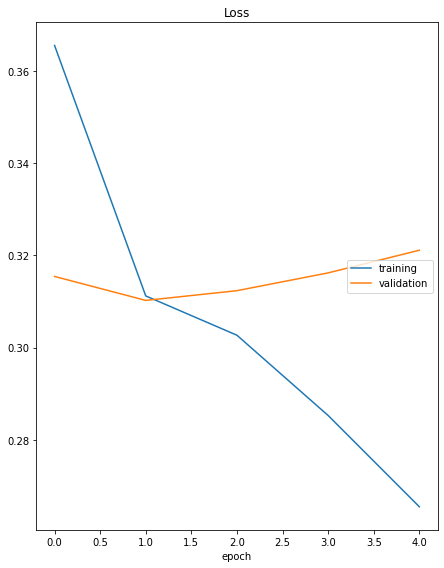

Loss
	training         	 (min:    0.265, max:    0.366, cur:    0.265)
	validation       	 (min:    0.310, max:    0.321, cur:    0.321)


In [26]:
# ['MLPModel', 'GMFModel', 'NeuMFModel']
# Fit method
nn_recommender = NNRecommender()
nn_recommender.fit(interactions_df, None, None)

In [27]:
# Recommender method

recommendations = nn_recommender.recommend(pd.DataFrame([[1], [2], [3], [4], [5]], columns=['user_id']), items_df, 10)

recommendations = pd.merge(recommendations, items_df, on='item_id', how='left')
display(HTML(recommendations.to_html()))

,user_id,item_id,score,item_term_WinterVacation,item_term_Easter,item_term_OffSeason,item_term_HighSeason,item_term_LowSeason,item_term_MayLongWeekend,item_term_NewYear,item_term_Christmas,item_length_of_stay_bucket_[0-1],item_length_of_stay_bucket_[2-3],item_length_of_stay_bucket_[4-7],item_length_of_stay_bucket_[8-inf],item_rate_plan_Standard,item_rate_plan_Nonref,item_room_segment_[0-160],item_room_segment_[160-260],item_room_segment_[260-360],item_room_segment_[360-500],item_room_segment_[500-900],item_n_people_bucket_[1-1],item_n_people_bucket_[2-2],item_n_people_bucket_[3-4],item_n_people_bucket_[5-inf],item_weekend_stay_True,item_weekend_stay_False
0,1,51,0.881945,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,1.0,0.0
1,1,22,0.863483,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,1.0,0.0
2,1,55,0.819735,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,0.0,1.0,0.0,0.0,1.0,0.0
3,1,211,0.718725,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,0.0,1.0,0.0,0.0,1.0,0.0
4,1,32,0.709183,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,1.0,0.0,0.0,1.0,0.0
5,1,83,0.704405,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,1.0
6,1,159,0.69275,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,1.0,0.0
7,1,9,0.670892,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,1.0,0.0
8,1,157,0.667008,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,1.0,0.0,0.0,1.0,0.0
9,1,76,0.666068,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,1.0,0.0


# Tuning method

In [13]:
from evaluation_and_testing.testing import evaluate_train_test_split_implicit

seed = 6789

In [14]:
from hyperopt import hp, fmin, tpe, Trials
import traceback

def tune_recommender(recommender_class, interactions_df, items_df, 
                     param_space, max_evals=1, show_progressbar=True, seed=6789):
    # Split into train_validation and test sets

    shuffle = np.arange(len(interactions_df))
    rng = np.random.RandomState(seed=seed)
    rng.shuffle(shuffle)
    shuffle = list(shuffle)

    train_test_split = 0.8
    split_index = int(len(interactions_df) * train_test_split)

    train_validation = interactions_df.iloc[shuffle[:split_index]]
    test = interactions_df.iloc[shuffle[split_index:]]

    # Tune

    def loss(tuned_params):
        recommender = recommender_class(seed=seed, **tuned_params)
        hr1, hr3, hr5, hr10, ndcg1, ndcg3, ndcg5, ndcg10 = evaluate_train_test_split_implicit(
            recommender, train_validation, items_df, seed=seed)
        return -hr10

    n_tries = 1
    succeded = False
    try_id = 0
    while not succeded and try_id < n_tries:
        try:
            trials = Trials()
            best_param_set = fmin(loss, space=param_space, algo=tpe.suggest, 
                                  max_evals=max_evals, show_progressbar=show_progressbar, trials=trials, verbose=True)
            succeded = True
        except:
            traceback.print_exc()
            try_id += 1
            
    if not succeded:
        return None
        
    # Validate
    
    recommender = recommender_class(seed=seed, **best_param_set)

    results = [[recommender_class.__name__] + list(evaluate_train_test_split_implicit(
        recommender, {'train': train_validation, 'test': test}, items_df, seed=seed))]

    results = pd.DataFrame(results, 
                           columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

    display(HTML(results.to_html()))
    
    return best_param_set

## Tuning of the recommender

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Tune your model using the code below. You only need to put the class name of your recommender and choose an appropriate parameter space.

### 1. Tuning of the Collaborative Recommender

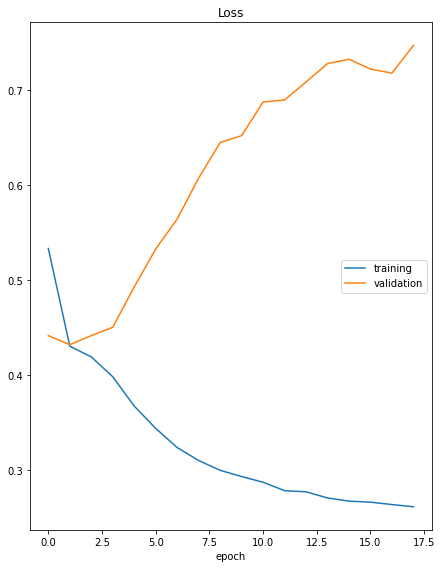

Loss                                                                                                                   
	training         	 (min:    0.262, max:    0.533, cur:    0.262)
	validation       	 (min:    0.432, max:    0.747, cur:    0.747)
 90%|████████████████████████████████████████▌    | 9/10 [1:12:17<07:15, 435.39s/trial, best loss: -0.2196360558611934]

'NeuMFModel'

100%|████████████████████████████████████████████| 10/10 [1:15:49<00:00, 454.98s/trial, best loss: -0.2196360558611934]


{'n_epochs': 10.0,
 'batch_size': 128.0,
 'learning_rate': 0.0066,
 'embedding_dim': 56,
 'device': device(type='cpu'),
 'weight_decay': 0.004,
 'model_class': None}

AttributeError: 'NoneType' object has no attribute 'train'

In [22]:
# Test for classic veresion of recommender (using pairs user & item ids)
param_space = {
    'n_neg_per_pos': hp.quniform('n_neg_per_pos', 1, 15, 1),
    'n_epochs': hp.quniform('n_epochs', 5, 30, 2),
    'batch_size': hp.quniform('batch_size', 16, 128, 4),
    'learning_rate': hp.quniform('learning_rate', 0.0001, 0.01, 0.0002),
    'embedding_dim': hp.quniform('embedding_dim', 16, 128, 8),
    'weight_decay': hp.quniform('weight_decay', 0.0001, 0.01, 0.0005),
    'model_class': 'NeuMFModel'
#    'model_class': hp.choice('model_class', {2: 'NeuMFModel'})
}

best_param_set = tune_recommender(NNRecommender, interactions_df, items_df,
                                  param_space, max_evals=10, show_progressbar=True, seed=seed)

print("Best parameters:")
print(best_param_set)

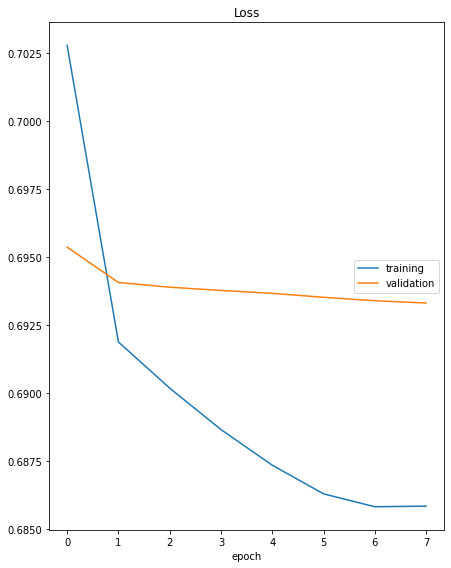

Loss                                                                                                                   
	training         	 (min:    0.686, max:    0.703, cur:    0.686)
	validation       	 (min:    0.693, max:    0.695, cur:    0.693)
 90%|███████████████████████████████████████▌    | 9/10 [1:10:38<06:31, 391.12s/trial, best loss: -0.22090562843842573]

'GMFModel'

100%|███████████████████████████████████████████| 10/10 [1:14:13<00:00, 445.34s/trial, best loss: -0.22090562843842573]


{'n_epochs': 8.0,
 'batch_size': 36.0,
 'learning_rate': 0.0088,
 'embedding_dim': 16,
 'device': device(type='cpu'),
 'weight_decay': 0.001,
 'model_class': None}

AttributeError: 'NoneType' object has no attribute 'train'

In [24]:
# Test for classic veresion of recommender (using pairs user & item ids)
param_space = {
    'n_neg_per_pos': hp.quniform('n_neg_per_pos', 1, 15, 1),
    'n_epochs': hp.quniform('n_epochs', 5, 30, 2),
    'batch_size': hp.quniform('batch_size', 16, 128, 4),
    'learning_rate': hp.quniform('learning_rate', 0.0001, 0.01, 0.0002),
    'embedding_dim': hp.quniform('embedding_dim', 16, 128, 8),
    'weight_decay': hp.quniform('weight_decay', 0.0001, 0.01, 0.0005),
    'model_class': 'GMFModel'
#    'model_class': hp.choice('model_class', {1: 'GMFModel'})
}

best_param_set = tune_recommender(NNRecommender, interactions_df, items_df,
                                  param_space, max_evals=10, show_progressbar=True, seed=seed)

print("Best parameters:")
print(best_param_set)

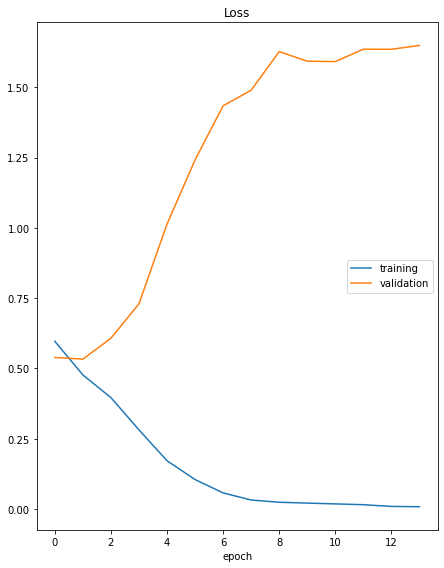

Loss                                                                                                                   
	training         	 (min:    0.008, max:    0.596, cur:    0.008)
	validation       	 (min:    0.533, max:    1.648, cur:    1.648)
 90%|███████████████████████████████████████▌    | 9/10 [1:40:31<11:02, 662.27s/trial, best loss: -0.22598391874735504]

'MLPModel'

100%|███████████████████████████████████████████| 10/10 [1:44:54<00:00, 629.49s/trial, best loss: -0.22598391874735504]


{'n_epochs': 18.0,
 'batch_size': 84.0,
 'learning_rate': 0.0082,
 'embedding_dim': 32,
 'device': device(type='cpu'),
 'weight_decay': 0.0085,
 'model_class': None}

AttributeError: 'NoneType' object has no attribute 'train'

In [25]:
# Test for classic veresion of recommender (using pairs user & item ids)
param_space = {
    'n_neg_per_pos': hp.quniform('n_neg_per_pos', 1, 15, 1),
    'n_epochs': hp.quniform('n_epochs', 5, 30, 2),
    'batch_size': hp.quniform('batch_size', 16, 128, 4),
    'learning_rate': hp.quniform('learning_rate', 0.0001, 0.01, 0.0002),
    'embedding_dim': hp.quniform('embedding_dim', 16, 128, 8),
    'weight_decay': hp.quniform('weight_decay', 0.0001, 0.01, 0.0005),
    'model_class': 'MLPModel'
#    'model_class': hp.choice('model_class', {0: 'MLPModel'})
}

best_param_set = tune_recommender(NNRecommender, interactions_df, items_df,
                                  param_space, max_evals=10, show_progressbar=True, seed=seed)

print("Best parameters:")
print(best_param_set)

### 2. Tuning of the Hybrid Recommender

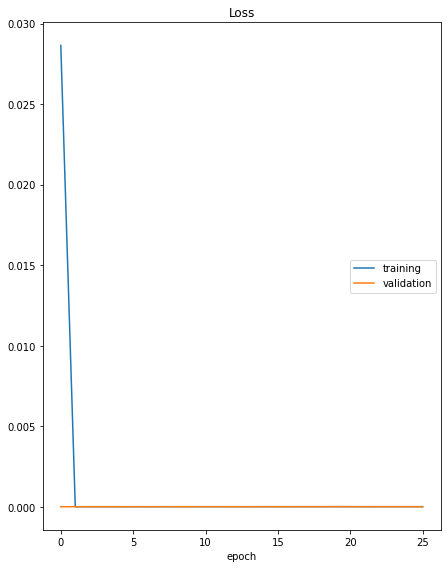

Loss
	training         	 (min:    0.000, max:    0.029, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,HybridNNRecommender,0.000339,0.001697,0.001697,0.002037,0.000339,0.001063,0.001063,0.00117


Best parameters:
{'batch_size': 60.0, 'embedding_dim': 72.0, 'learning_rate': 0.0098, 'n_epochs': 26.0, 'n_neg_per_pos': 2.0, 'weight_decay': 0.0075}


In [23]:
param_space = {
    'n_neg_per_pos': hp.quniform('n_neg_per_pos', 1, 15, 1),
    'n_epochs': hp.quniform('n_epochs', 5, 30, 2),
    'batch_size': hp.quniform('batch_size', 16, 128, 4),
    'learning_rate': hp.quniform('learning_rate', 0.0001, 0.01, 0.0002),
    'embedding_dim': hp.quniform('embedding_dim', 16, 128, 8),
    'weight_decay': hp.quniform('weight_decay', 0.0001, 0.01, 0.0005)
}

best_param_set = tune_recommender(HybridNNRecommender, interactions_df, items_df,
                                  param_space, max_evals=10, show_progressbar=True, seed=seed)

print("Best parameters:")
print(best_param_set)

# Final evaluation

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Run the final evaluation of your recommender and present its results against the Amazon and Netflix recommenders' results. You just need to give the class name of your recommender and its tuned parameters below.

It's optional, but for better effect you can include here the results from all recommenders created during in this class.

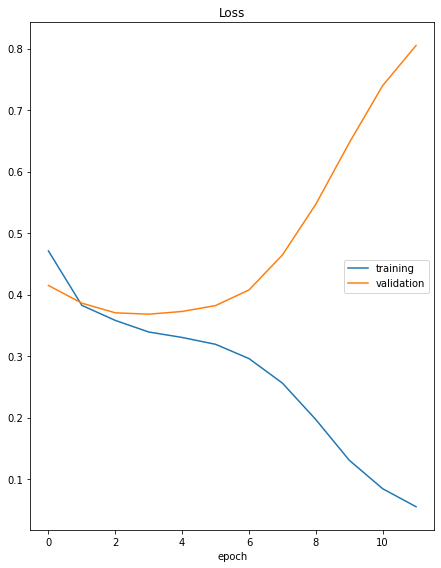

Loss
	training         	 (min:    0.055, max:    0.471, cur:    0.055)
	validation       	 (min:    0.368, max:    0.805, cur:    0.805)


'MLPModel'

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NNRecommender,0.047183,0.127291,0.173795,0.241005,0.047183,0.09297,0.112403,0.133891


In [31]:
nn_recommender = NNRecommender( 
                      batch_size=96.0,
                      embedding_dim=88.0,
                      learning_rate=0.001,
                      n_epochs=12.0,
                      n_neg_per_pos = 4.0,
                      weight_decay = 0.0075,
                      model_class = 'MLPModel')  # Initialize your recommender here

# Give the name of your recommender in the line below
nn_tts_results = [['NNRecommender'] + list(evaluate_train_test_split_implicit(
    nn_recommender, interactions_df, items_df))]

nn_tts_results = pd.DataFrame(
    nn_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(nn_tts_results.to_html()))

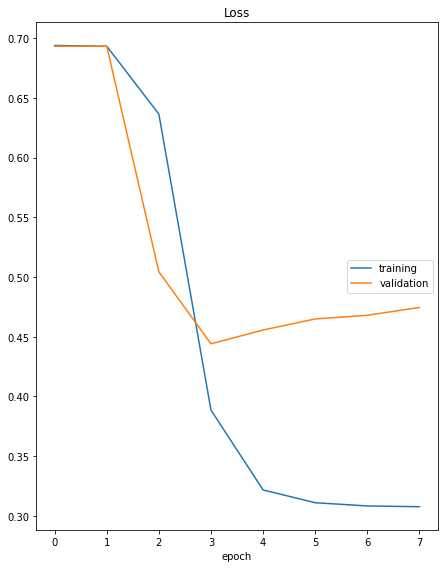

Loss
	training         	 (min:    0.308, max:    0.694, cur:    0.308)
	validation       	 (min:    0.444, max:    0.693, cur:    0.475)


'GMFModel'

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NNRecommender,0.046843,0.124915,0.169722,0.233198,0.046843,0.09139,0.110122,0.130402


In [27]:
gmf_nn_recommender = NNRecommender( 
                      batch_size=36.0,
                      embedding_dim=16,
                      learning_rate=0.0088,
                      n_epochs=8.0,
                      n_neg_per_pos = 4.0,
                      weight_decay = 0.001,
                      model_class = 'GMFModel')  # Initialize your recommender here

# Give the name of your recommender in the line below
gmf_tts_results = [['NNRecommender'] + list(evaluate_train_test_split_implicit(
    gmf_nn_recommender, interactions_df, items_df))]

gmf_tts_results = pd.DataFrame(
    gmf_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(gmf_tts_results.to_html()))

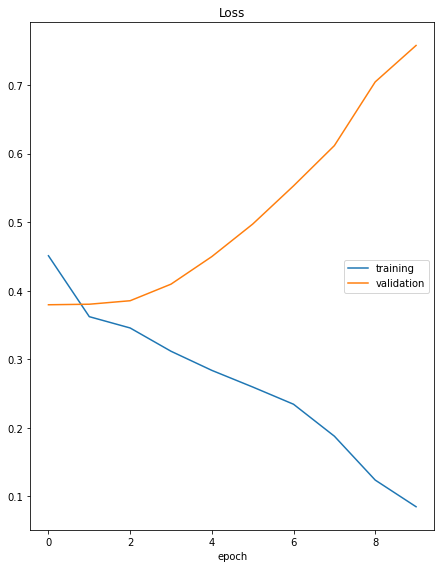

Loss
	training         	 (min:    0.085, max:    0.451, cur:    0.085)
	validation       	 (min:    0.380, max:    0.758, cur:    0.758)


'NeuMFModel'

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NNRecommender,0.04888,0.127291,0.169722,0.234895,0.04888,0.093685,0.111424,0.132148


In [28]:
neu_nn_recommender = NNRecommender( 
                      batch_size=128.0,
                      embedding_dim=56,
                      learning_rate=0.0066,
                      n_epochs=10.0,
                      n_neg_per_pos = 4.0,
                      weight_decay = 0.004,
                      model_class = 'NeuMFModel')  # Initialize your recommender here

# Give the name of your recommender in the line below
neu_tts_results = [['NNRecommender'] + list(evaluate_train_test_split_implicit(
    neu_nn_recommender, interactions_df, items_df))]

neu_tts_results = pd.DataFrame(
    neu_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(neu_tts_results.to_html()))

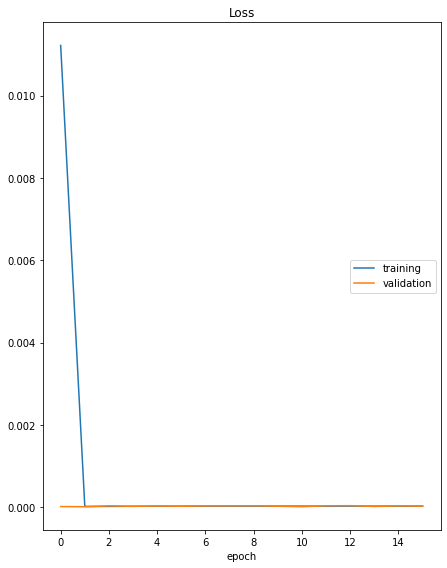

Loss
	training         	 (min:    0.000, max:    0.011, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,HybridNNRecommender,0.000339,0.001697,0.001697,0.002037,0.000339,0.001063,0.001063,0.00117


In [35]:
hybrid_nn_recommender = HybridNNRecommender(
                            batch_size = 20.0,
                            embedding_dim = 120.0,
                            learning_rate = 0.0078000000000000005,
                            n_epochs = 16.0,
                            n_neg_per_pos = 12.0,
                            weight_decay = 0.0095
                        )  # Initialize your recommender here

# Give the name of your recommender in the line below
hybrid_tts_results = [['HybridNNRecommender'] + list(evaluate_train_test_split_implicit(
    hybrid_nn_recommender, interactions_df, items_df))]

hybrid_tts_results = pd.DataFrame(
    hybrid_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(hybrid_tts_results.to_html()))

In [37]:
from recommenders.amazon_recommender import AmazonRecommender

amazon_recommender = AmazonRecommender()

amazon_tts_results = [['AmazonRecommender'] + list(evaluate_train_test_split_implicit(
    amazon_recommender, interactions_df, items_df))]

amazon_tts_results = pd.DataFrame(
    amazon_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(amazon_tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,AmazonRecommender,0.044128,0.118805,0.160557,0.223693,0.044128,0.086755,0.104216,0.124468


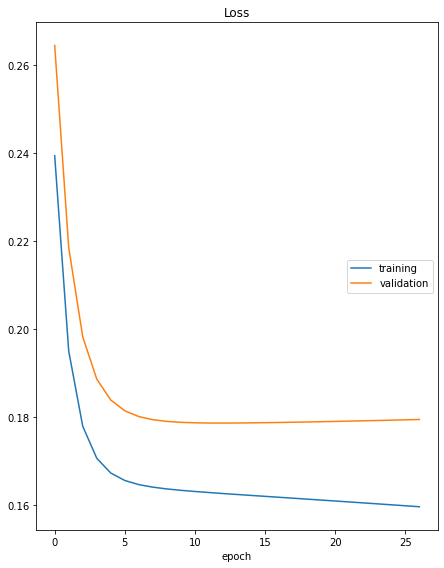

Loss
	training         	 (min:    0.160, max:    0.239, cur:    0.160)
	validation       	 (min:    0.179, max:    0.264, cur:    0.180)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NetflixRecommender,0.044128,0.120163,0.162593,0.225051,0.044128,0.087478,0.105202,0.125176


In [39]:
from recommenders.netflix_recommender import NetflixRecommender

netflix_recommender = NetflixRecommender(embedding_dim=8, n_epochs=30, print_type='live') #n_epoch=200

netflix_tts_results = [['NetflixRecommender'] + list(evaluate_train_test_split_implicit(
    netflix_recommender, interactions_df, items_df))]

netflix_tts_results = pd.DataFrame(
    netflix_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(netflix_tts_results.to_html()))

In [40]:
tts_results = pd.concat([nn_tts_results, gmf_tts_results, neu_tts_results, hybrid_tts_results, amazon_tts_results, netflix_tts_results]).reset_index(drop=True)
display(HTML(tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NNRecommender,0.047183,0.127291,0.173795,0.241005,0.047183,0.092970,0.112403,0.133891
1,NNRecommender,0.046843,0.124915,0.169722,0.233198,0.046843,0.091390,0.110122,0.130402
2,NNRecommender,0.048880,0.127291,0.169722,0.234895,0.048880,0.093685,0.111424,0.132148
3,HybridNNRecommender,0.000339,0.001697,0.001697,0.002037,0.000339,0.001063,0.001063,0.001170
4,AmazonRecommender,0.044128,0.118805,0.160557,0.223693,0.044128,0.086755,0.104216,0.124468
5,NetflixRecommender,0.044128,0.120163,0.162593,0.225051,0.044128,0.087478,0.105202,0.125176


# Summary

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Write a summary of your experiments. What worked well and what did not? What are your thoughts how could you possibly further improve the model?

### Tuning
I get low results. And encountered a strange error in selecting the network model name
```
'model_class': hp.choice('model_class', {0: 'MLPModel'})
'model_class': hp.choice('model_class', ['MLPModel'])
```
None of these methods worked when the test was finally run. reccomender gets `0` or `None` for `model_class` variable that's why I decided to print the parameters passed to the constructor and fire the result in the final test.

### Scores
- MLPModel - my parameters were better than tuning result
- In other models scores are surprisingly low despite being returned by tuning. 

In fact all scores from Collaborative model are less than 0.25 in 10HR. I expected at least one bigger score. 

### Collaborative Recommender
Works fine. There are many ready-made models and its easy to test them. Fast tuning with hight scores.

During the tests i could observe many different plots

### Hybrid Recommender
Unfortunately I am not satisfied with this recommendation.
There are many strange things.
- I don't know why my recommender always return only scoer = 1 in fast test but I think its suspicious
- Plot is always a horizontal line
- Tuning is too fast for me
- Scoers are very low and I dont know why and how to change it. Its probably because of Net model

There are many clues that suggest something is not working properly but i dont know what and why.

#### MyContentBaseNet
Its more simple than i oryginally try to be. At the beginning I tried to create much more interesting network using, for example CosineSimilarity and vector normalisation, but during the work I encountered various errors and I couldn't finish it, so I finally prepared a model with 3 simple linear hidden layers


### Conclusion
In future i could try to prepare better Net model and try to use embedding in it.
I can also prepare best users an items features

# My sources

Basics:
1. https://towardsdatascience.com/deep-learning-with-python-neural-networks-complete-tutorial-6b53c0b06af0
2. https://www.youtube.com/watch?v=ZkBQ6YA9E40
3. https://towardsdatascience.com/modern-recommendation-systems-with-neural-networks-3cc06a6ded2c
4. https://towardsdatascience.com/a-complete-guide-to-recommender-system-tutorial-with-sklearn-surprise-keras-recommender-5e52e8ceace1
